# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

*Это достаточно объемное и сложное домашнее задание, но не пугайтесь --  вы уже обладаете всеми знаниями, которые необходимы для его решения. Отметим, что уметь дообучить сеть является необходимим навыком на практике.*

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. 

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [2]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ps4zxkv1
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ps4zxkv1
  Resolved https://github.com/rcmalli/keras-vggface.git to commit 719ad75625fe51436b9a9479114b3d136847e11a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8324 sha256=876572d14399cb878af5bdd49938c427163c16de7a5aea5ce80547d34d7f856d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tki8sd4g/wheels/7a/c1/6e/91fe8b6b4e174d76dfe5cdbe81806ea3439fdd681c289e73f8
Successfully built keras-vggface


In [3]:
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pip install keras_vggface --no-deps
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.9/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

from keras_vggface.vggface import VGGFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [5]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
100%|██████████| 166M/166M [00:02<00:00, 77.8MB/s]


'resnet50face.h5'

In [6]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [7]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [8]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2023-04-15 17:38:32--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.21.83.52, 172.67.214.206, 2606:4700:3033::6815:5334, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.21.83.52|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2023-04-15 17:38:33--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 172.67.162.235, 104.21.73.131, 2606:4700:3031::6815:4983, ...
Connecting to img.joinfo.com (img.joinfo.com)|172.67.162.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.002s  

2023-04-15 17:38:34 (20.9 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

1346516/1346516 [==============================] - 0s 0us/step


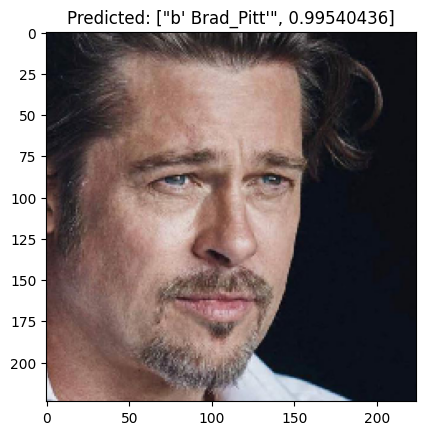

In [9]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных

In [10]:
from pathlib import Path
from collections import Counter

In [11]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
100%|██████████| 107M/107M [00:01<00:00, 95.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 144MB/s]


'train_val_split_utk.csv'

In [12]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['21_1_1_20170112192955750.jpg.chip.jpg', '40_1_3_20170117151929587.jpg.chip.jpg', '36_0_0_20170104172716658.jpg.chip.jpg']


In [13]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,59_0_0_20170111205304095.jpg.chip.jpg,0.508621,0,0
1,64_0_1_20170120224617161.jpg.chip.jpg,0.551724,1,0
2,72_1_0_20170110183029618.jpg.chip.jpg,0.620690,0,1
3,26_1_2_20170116183651297.jpg.chip.jpg,0.224138,2,1
4,26_0_1_20170113152835192.jpg.chip.jpg,0.224138,1,0


In [53]:
df.describe(include = "all")

,img_name,age,race,gender
count,23705,23705.000000,23705,23705
unique,23705,NaN,5,2
top,59_0_0_20170111205304095.jpg.chip.jpg,NaN,0,0
freq,1,NaN,10078,12391
mean,NaN,0.287077,NaN,NaN
std,NaN,0.171429,NaN,NaN
min,NaN,0.008621,NaN,NaN
25%,NaN,0.198276,NaN,NaN
50%,NaN,0.250000,NaN,NaN
75%,NaN,0.387931,NaN,NaN


In [14]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [39]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

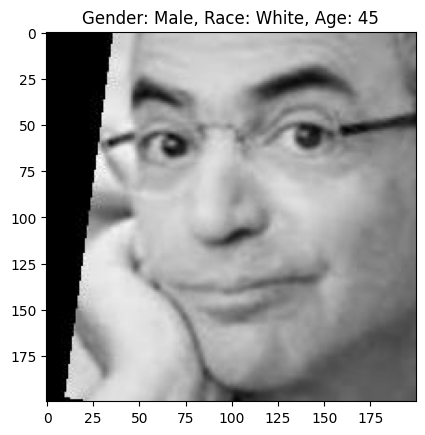

In [16]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


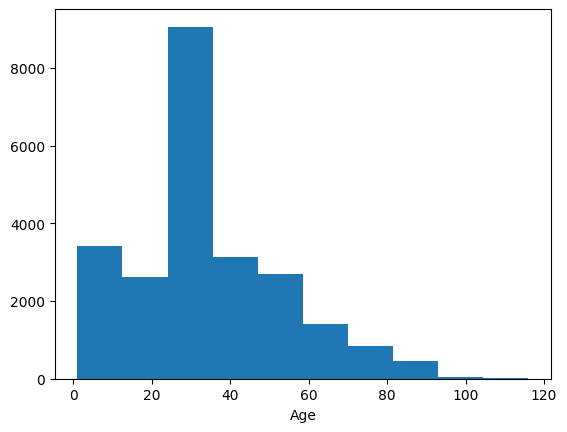

In [17]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    x = np.expand_dims(image_, axis=0)
    x = utils.preprocess_input(x, version=2)
    
    # < YOUR CODE ENDS HERE >
    return x

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        x_col="img_name", y_col="gender",
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        x_col="img_name", y_col="gender", 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False)


Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Female


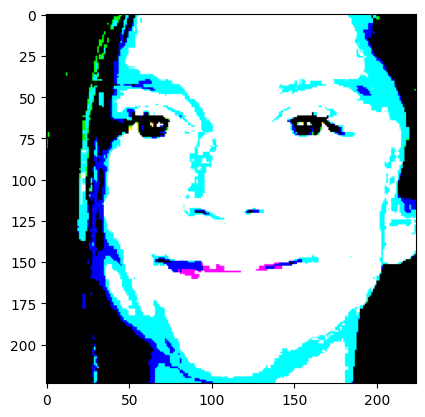

In [21]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])

In [22]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

144.5047 -131.0912


Female


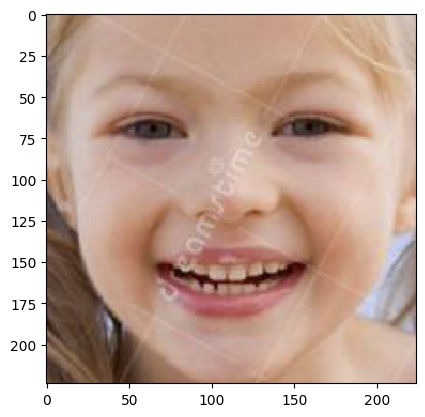

In [41]:
def deprocess_image(vggface_image):
   
    image = np.copy(vggface_image) 

    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]

    return np.uint8(image)

plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

## Задание 3. Обучение модели предсказания пола

In [24]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [25]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = Path("/content/drive/My Drive/model_gender")
path.mkdir(exist_ok=True, parents=True) 
cpt_filename = "checkpoint_best.h5"  
cpt_gender =str(path / cpt_filename)

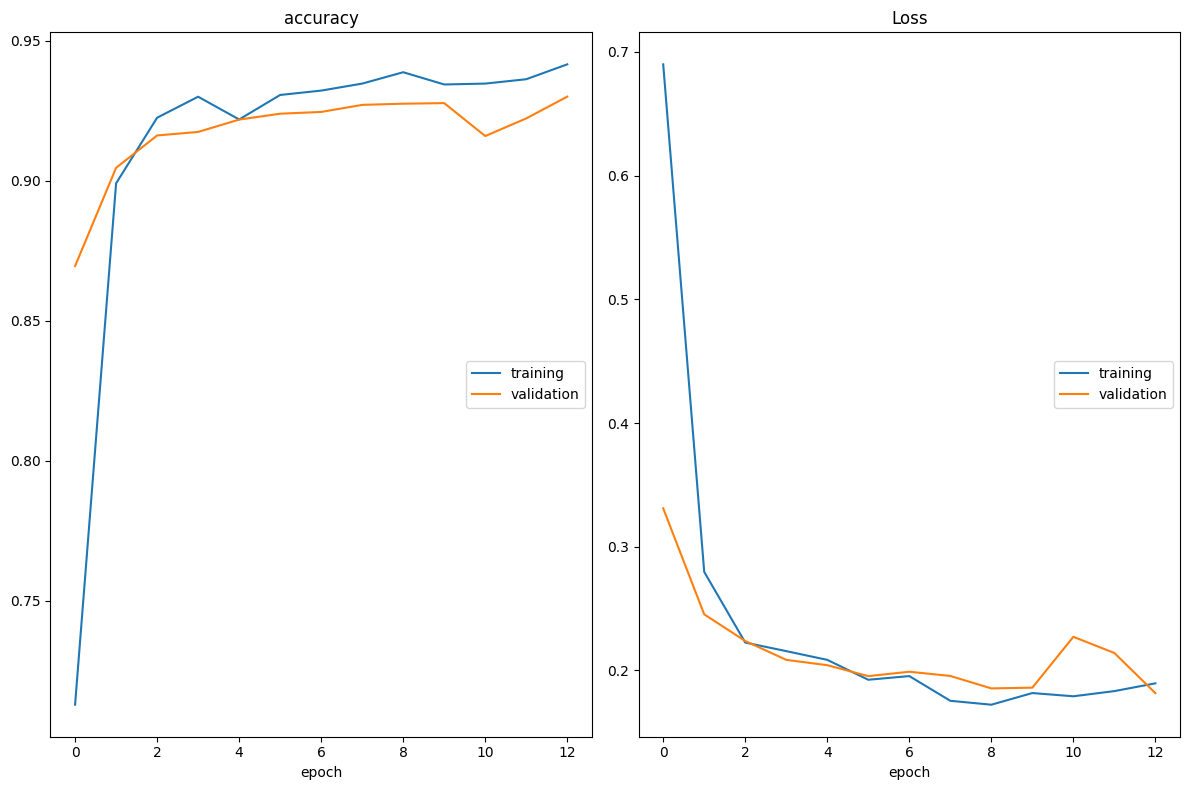

accuracy
	training         	 (min:    0.713, max:    0.942, cur:    0.942)
	validation       	 (min:    0.870, max:    0.930, cur:    0.930)
Loss
	training         	 (min:    0.172, max:    0.690, cur:    0.190)
	validation       	 (min:    0.182, max:    0.331, cur:    0.182)

Epoch 13: val_accuracy improved from 0.92772 to 0.93003, saving model to /content/drive/My Drive/model_gender/checkpoint_best.h5
25/25 [==============================] - 28s 1s/step - loss: 0.1895 - accuracy: 0.9416 - val_loss: 0.1816 - val_accuracy: 0.9300


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience = 5, 
    min_delta=0.01, 
    mode='max'
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_gender, monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, 
                                                mode='max')

EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), custom_early_stopping, checkpoint])

In [ ]:
model_gender = load_model(cpt_gender)
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 17s 432ms/step - loss: 0.1816 - accuracy: 0.9300
Very good! Can you improve accuracy?


In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23561152  
                                                                 
 dense_1 (Dense)             (None, 64)                131136    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,692,353
Trainable params: 131,201
Non-trainable params: 23,561,152
_________________________________________________________________


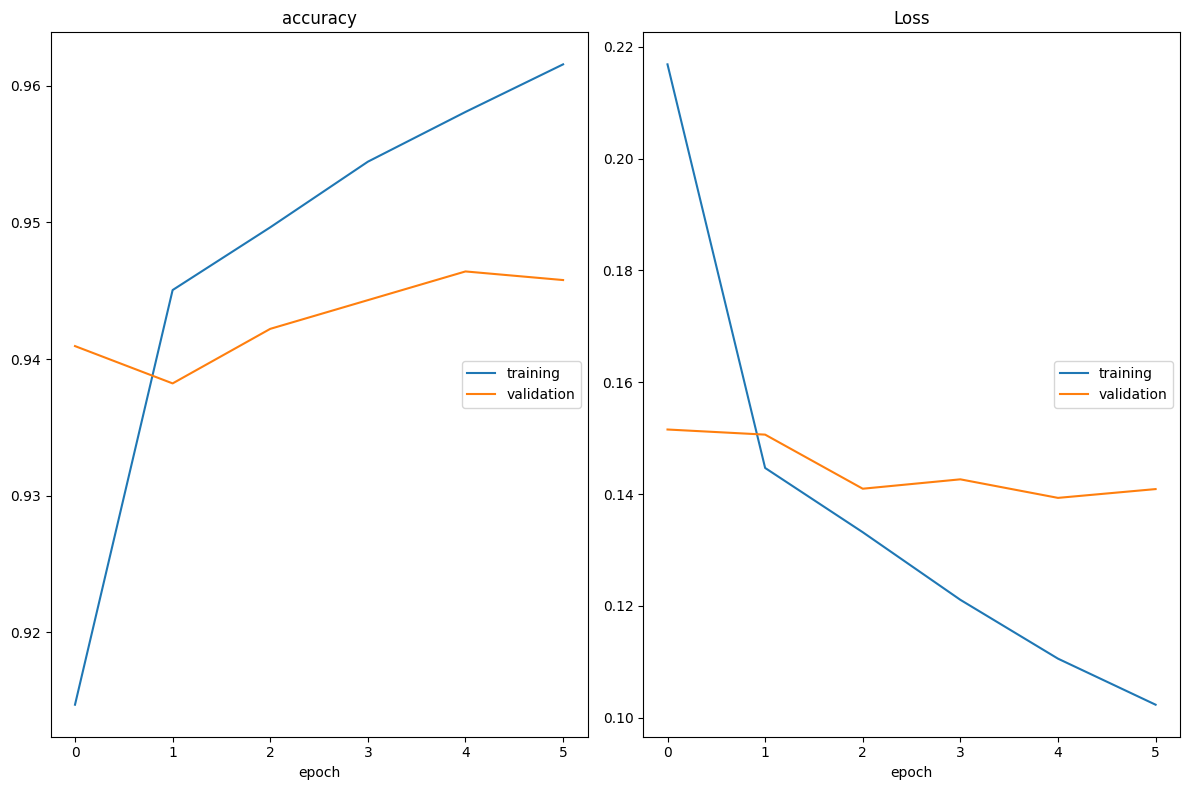

accuracy
	training         	 (min:    0.915, max:    0.962, cur:    0.962)
	validation       	 (min:    0.938, max:    0.946, cur:    0.946)
Loss
	training         	 (min:    0.102, max:    0.217, cur:    0.102)
	validation       	 (min:    0.139, max:    0.152, cur:    0.141)

Epoch 6: val_accuracy did not improve from 0.94642
149/149 [==============================] - 80s 540ms/step - loss: 0.1023 - accuracy: 0.9616 - val_loss: 0.1409 - val_accuracy: 0.9458


In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), custom_early_stopping, checkpoint])

In [ ]:
model_gender = load_model(cpt_gender)
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 17s 431ms/step - loss: 0.1393 - accuracy: 0.9464
Well done!


In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))
fine_tune_at = 110
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), # уменьшили скорость обучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Количество слоев в базовой модели:  175


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23561152  
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,823,553
Trainable params: 18,578,689
Non-trainable params: 5,244,864
_________________________________________________________________


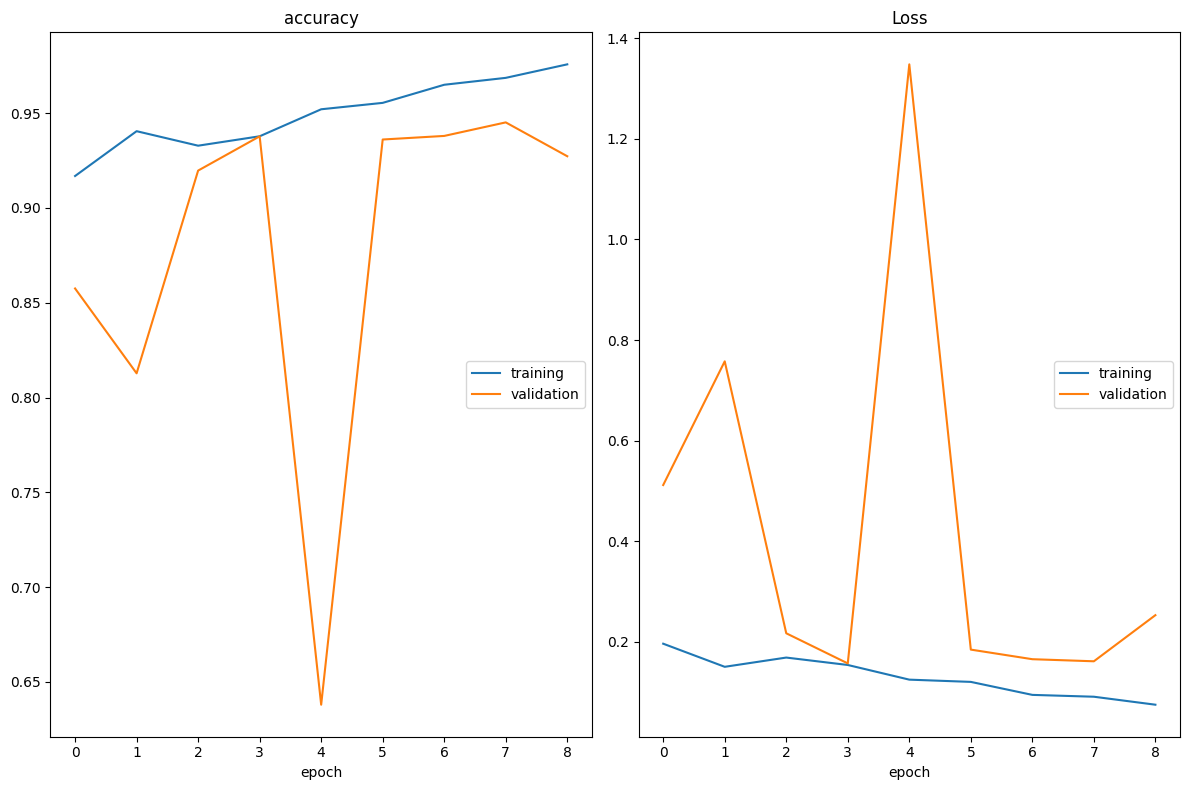

accuracy
	training         	 (min:    0.917, max:    0.976, cur:    0.976)
	validation       	 (min:    0.638, max:    0.945, cur:    0.927)
Loss
	training         	 (min:    0.075, max:    0.196, cur:    0.075)
	validation       	 (min:    0.157, max:    1.348, cur:    0.253)

Epoch 9: val_accuracy did not improve from 0.94642
149/149 [==============================] - 105s 703ms/step - loss: 0.0751 - accuracy: 0.9758 - val_loss: 0.2531 - val_accuracy: 0.9273


In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), custom_early_stopping, checkpoint])

In [ ]:
model_gender = load_model(cpt_gender)
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 17s 422ms/step - loss: 0.1393 - accuracy: 0.9464
Well done!


In [42]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

4/4 [==============================] - 2s 60ms/step


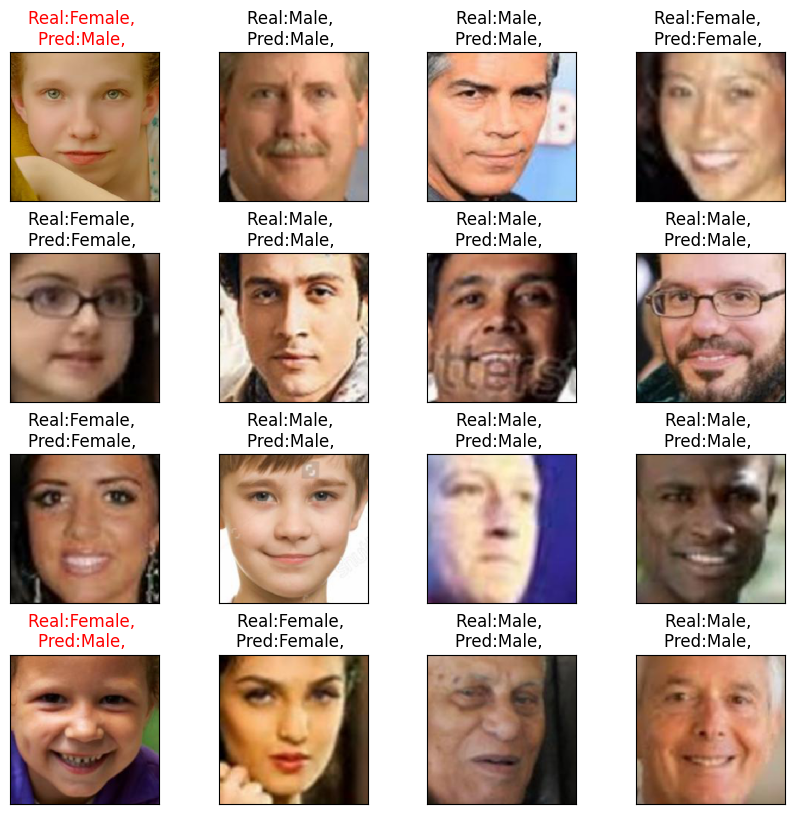

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

## Задание 4. Обучение модели предсказания расы

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
# < YOUR CODE STARTS HERE >
# train_generator = image_gen.flow_from_dataframe( ... ), 
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        x_col="img_name", y_col="race",
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        x_col="img_name", y_col="race", 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


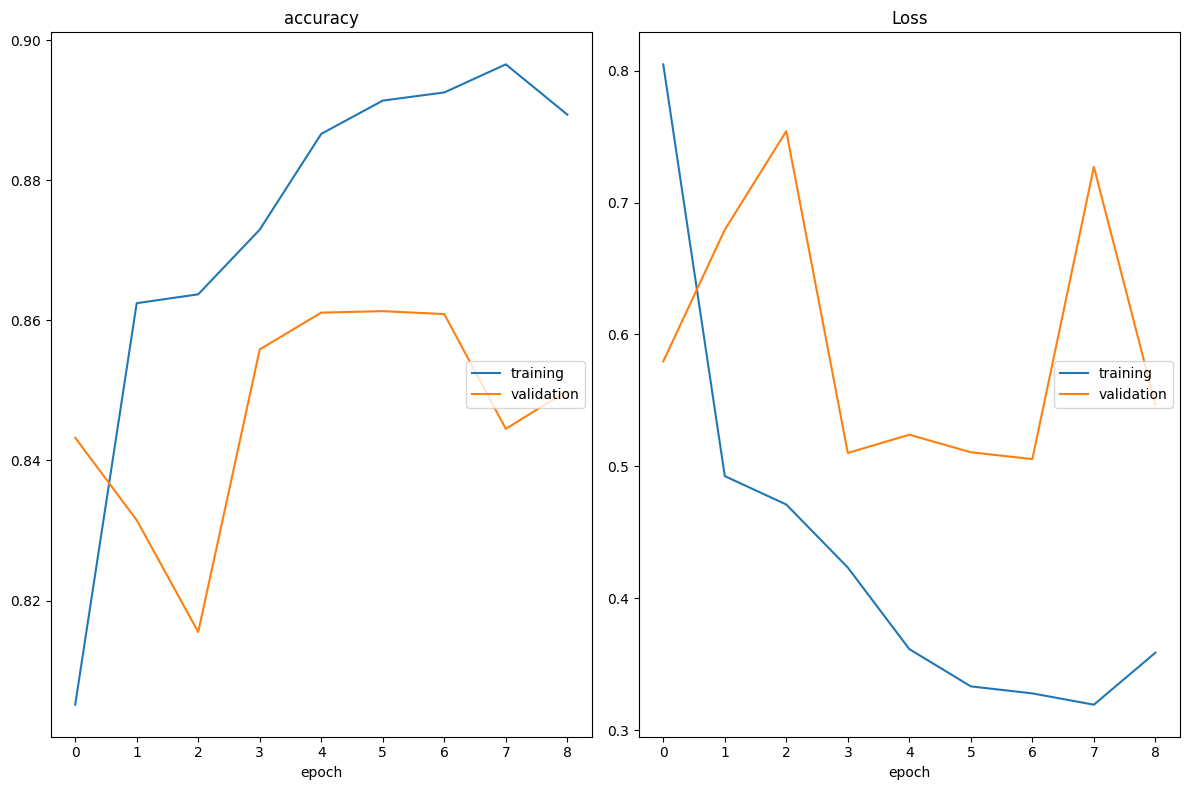

accuracy
	training         	 (min:    0.805, max:    0.897, cur:    0.889)
	validation       	 (min:    0.816, max:    0.861, cur:    0.850)
Loss
	training         	 (min:    0.319, max:    0.805, cur:    0.359)
	validation       	 (min:    0.505, max:    0.754, cur:    0.547)

Epoch 9: val_accuracy did not improve from 0.86132
149/149 [==============================] - 83s 553ms/step - loss: 0.3587 - accuracy: 0.8894 - val_loss: 0.5468 - val_accuracy: 0.8500


In [ ]:
# Обучение модели предсказания расы
path = Path("/content/drive/My Drive/model_race")
path.mkdir(exist_ok=True, parents=True)
cpt_filename = "checkpoint_best.h5"  
cpt_race =str(path / cpt_filename)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience = 5, 
    min_delta=0.01, 
    mode='max'
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_race, monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, 
                                                mode='max')
EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), custom_early_stopping, checkpoint])

In [ ]:
# < YOUR CODE ENDS HERE >

In [ ]:
model_race = load_model(cpt_race)
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 17s 416ms/step - loss: 0.5107 - accuracy: 0.8613
Well done!


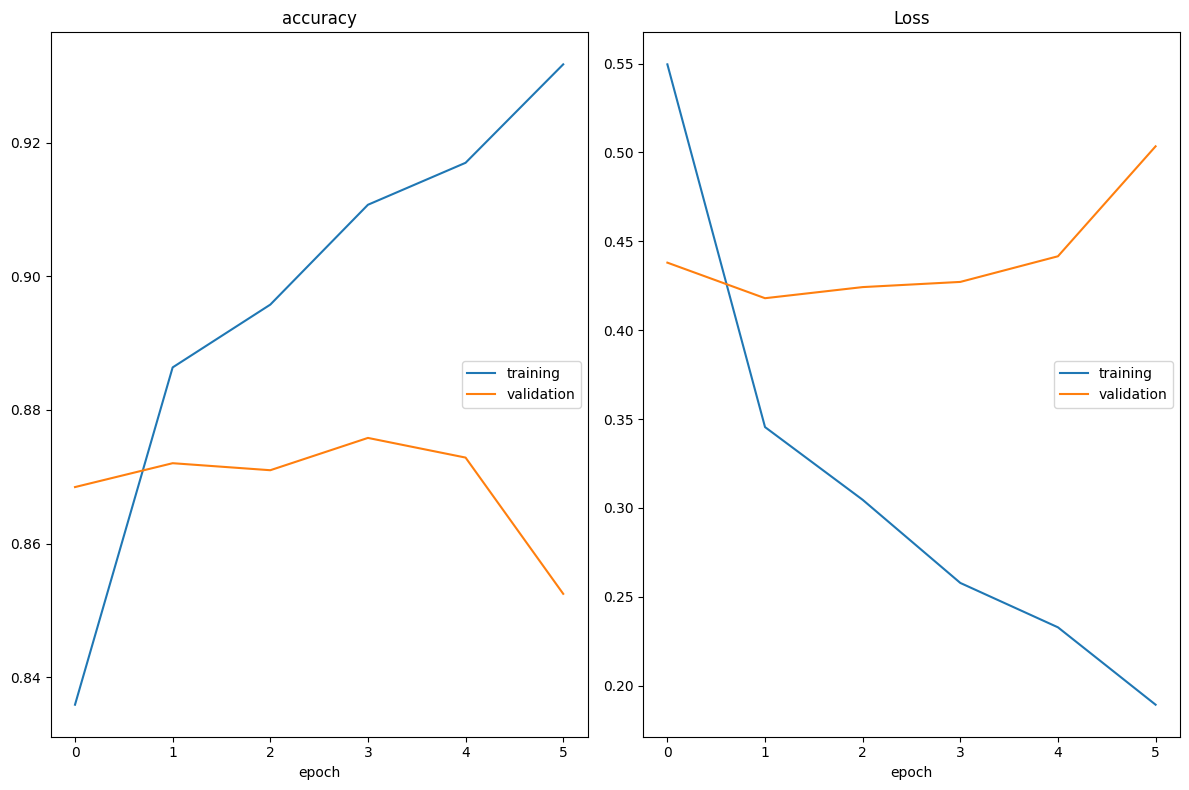

accuracy
	training         	 (min:    0.836, max:    0.932, cur:    0.932)
	validation       	 (min:    0.852, max:    0.876, cur:    0.852)
Loss
	training         	 (min:    0.189, max:    0.550, cur:    0.189)
	validation       	 (min:    0.418, max:    0.503, cur:    0.503)

Epoch 6: val_accuracy did not improve from 0.87581
149/149 [==============================] - 82s 552ms/step - loss: 0.1893 - accuracy: 0.9317 - val_loss: 0.5035 - val_accuracy: 0.8525


In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), custom_early_stopping, checkpoint])

In [ ]:
model_race = load_model(cpt_race)
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 17s 428ms/step - loss: 0.4272 - accuracy: 0.8758
Well done!


4/4 [==============================] - 1s 97ms/step


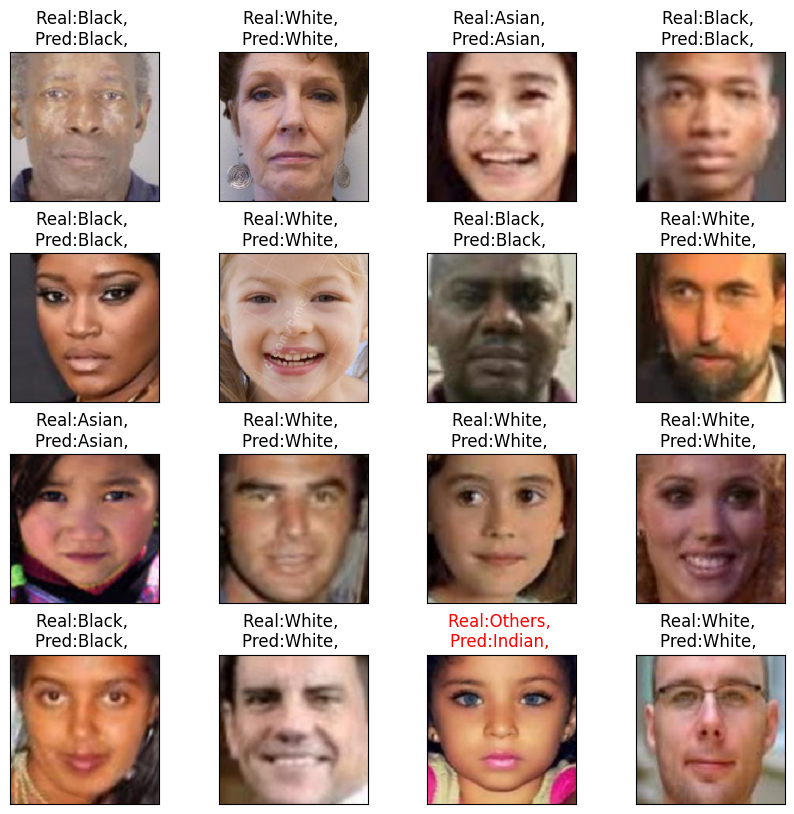

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

In [27]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2048)         23561152    ['input_2[0][0]']                
                                                                                                  
 layer_2 (Dense)                (None, 2048)         4196352     ['model_1[1][0]']                
                                                                                                  
 gender (Dense)                 (None, 1)            2049        ['layer_2[0][0]']          

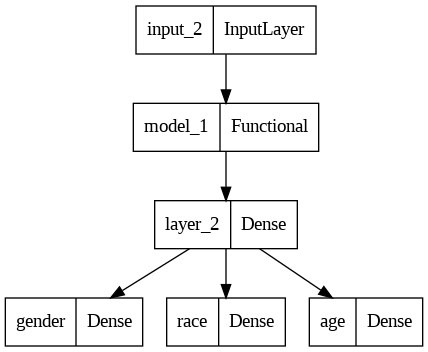

In [33]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
from keras import regularizers
from tensorflow.keras import layers

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_layer = base_model(input_layer)
layer_2 = layers.Dense(2048, name="layer_2", activation='relu',
kernel_regularizer=regularizers.l2(0.001), 
                 activity_regularizer=regularizers.l1(0.01))(base_layer)                     
gender_output = layers.Dense(1, name="gender", activation='sigmoid')(layer_2) 
race_output = layers.Dense(5, name="race", activation='softmax')(layer_2) 
age_output = layers.Dense(1, name="age", activation='relu')(layer_2) 
model = tf.keras.Model(inputs=input_layer, 
                    outputs=[gender_output, race_output, age_output])

model.summary()
plot_model(model)


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [30]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype(np.float32), 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


А теперь перейдем к обучению:

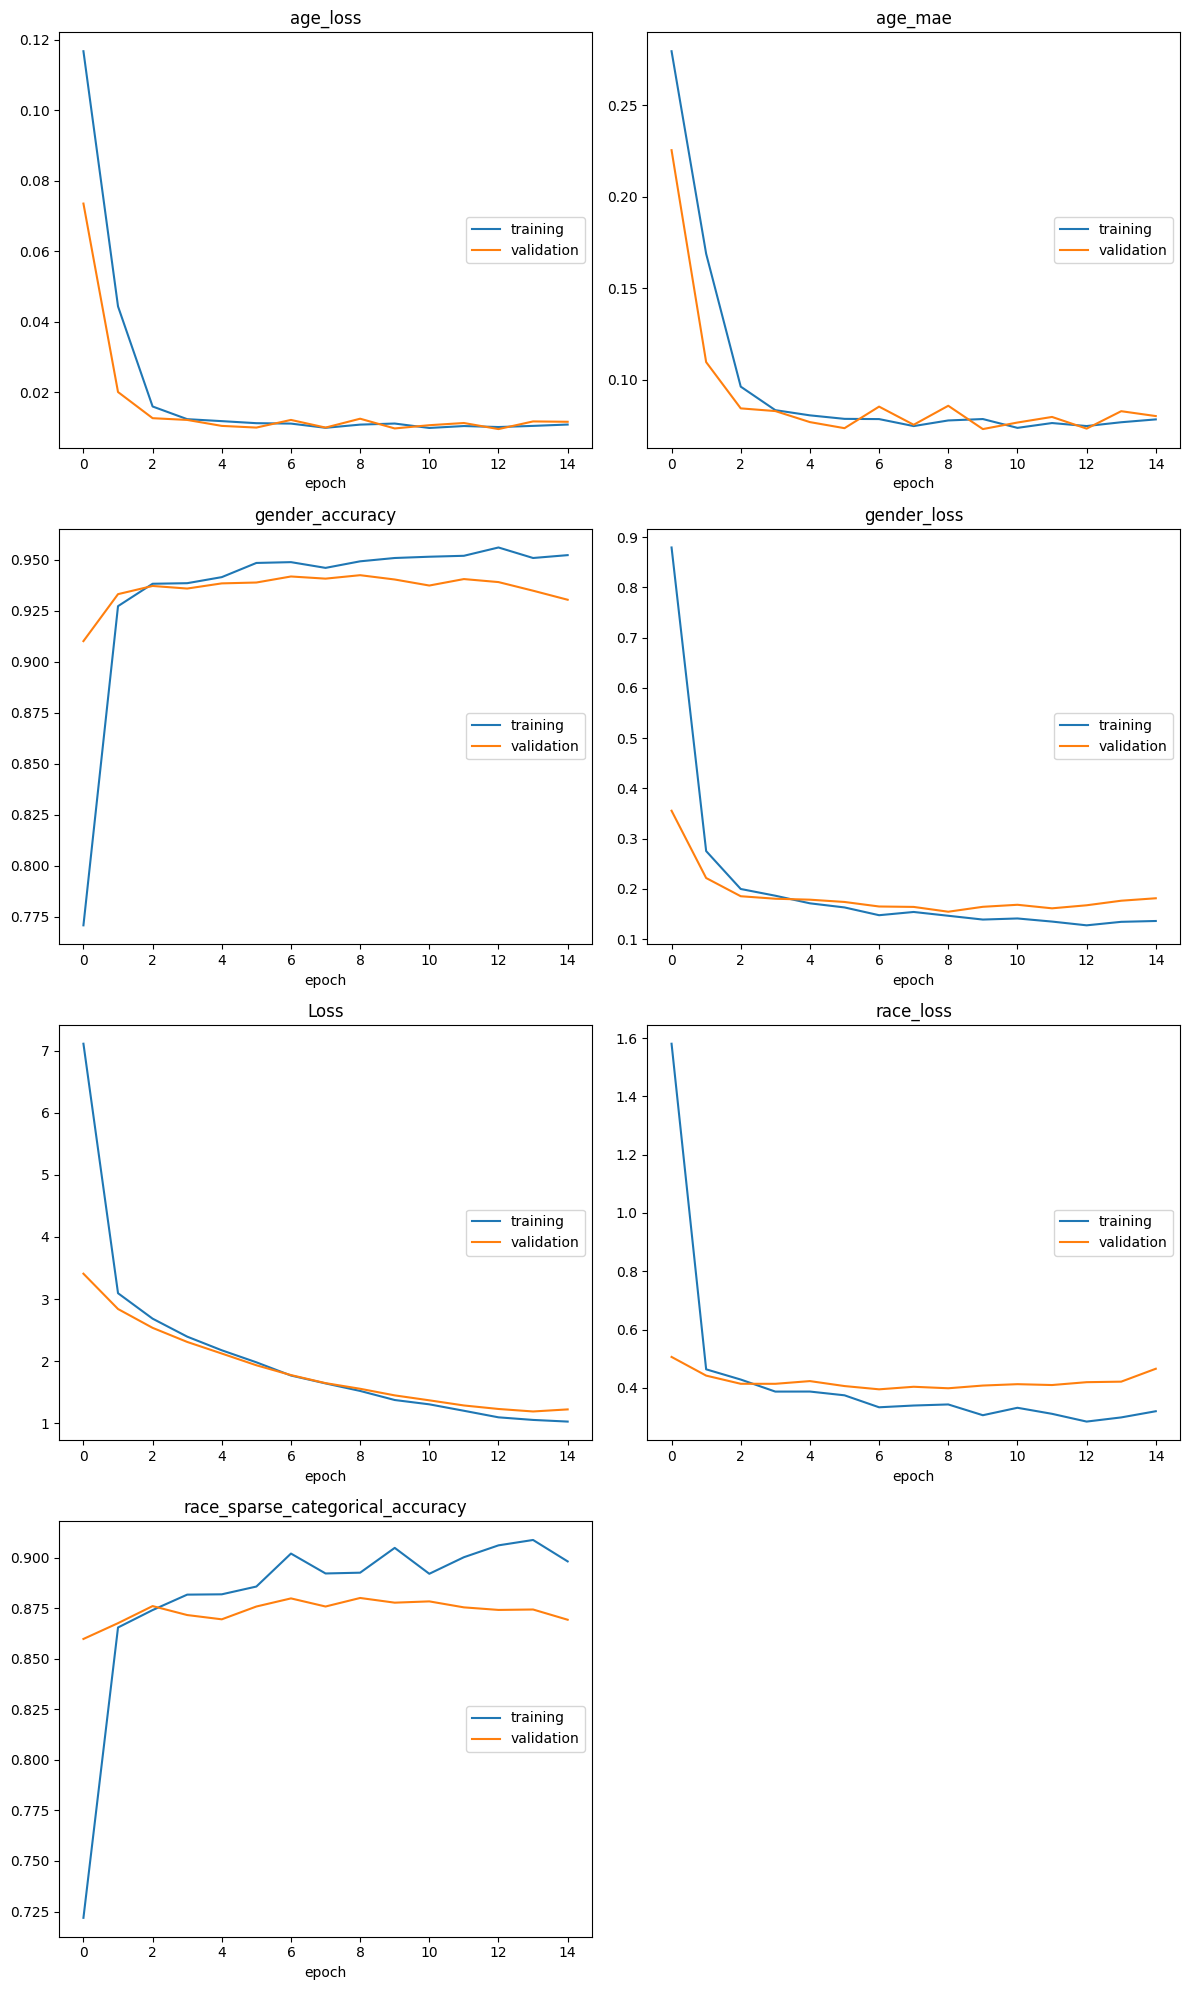

age_loss
	training         	 (min:    0.010, max:    0.117, cur:    0.011)
	validation       	 (min:    0.010, max:    0.074, cur:    0.012)
age_mae
	training         	 (min:    0.074, max:    0.280, cur:    0.078)
	validation       	 (min:    0.073, max:    0.226, cur:    0.080)
gender_accuracy
	training         	 (min:    0.771, max:    0.956, cur:    0.952)
	validation       	 (min:    0.910, max:    0.942, cur:    0.930)
gender_loss
	training         	 (min:    0.127, max:    0.879, cur:    0.136)
	validation       	 (min:    0.155, max:    0.356, cur:    0.181)
Loss
	training         	 (min:    1.026, max:    7.114, cur:    1.026)
	validation       	 (min:    1.189, max:    3.409, cur:    1.222)
race_loss
	training         	 (min:    0.284, max:    1.581, cur:    0.320)
	validation       	 (min:    0.395, max:    0.506, cur:    0.466)
race_sparse_categorical_accuracy
	training         	 (min:    0.722, max:    0.909, cur:    0.898)
	validation       	 (min:    0.860, max:    0.880

In [34]:
metric_race = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': metric_race, 'age': 'mae'})

path = Path("/content/drive/My Drive/model_multitask")
path.mkdir(exist_ok=True, parents=True) 
cpt_filename = "checkpoint_best.h5"  
cpt_multitask = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_multitask, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [35]:
model_multitask = load_model(cpt_multitask)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 20s 543ms/step - loss: 1.2219 - gender_loss: 0.1822 - race_loss: 0.4646 - age_loss: 0.0116 - gender_accuracy: 0.9301 - race_sparse_categorical_accuracy: 0.8697 - age_mae: 0.0803
Well done!


4/4 [==============================] - 0s 98ms/step


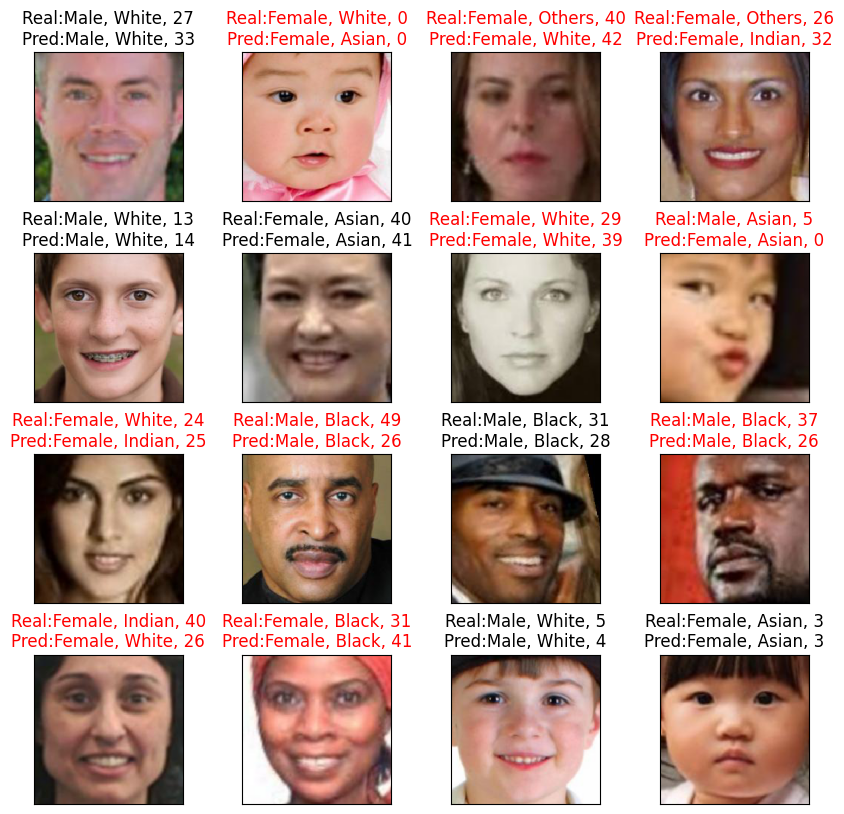

In [43]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )